# Proyecto 03 - Procesamiento del Lenguaje Natural

## Dataset: The Multilingual Amazon Reviews Corpus

**Recuerda descargar el dataset de [aquí](https://github.com/kang205/SASRec). Es un archivo .zip que contiene tres documentos. Más información sobre el dataset [aquí](https://registry.opendata.aws/amazon-reviews-ml/). Es importante que tengas en cuenta la [licencia](https://docs.opendata.aws/amazon-reviews-ml/license.txt) de este dataset.**

### Exploración de datos y Procesamiento del Lenguaje Natural

Dedícale un buen tiempo a hacer un Análisis Exploratorio de Datos. Considera que hasta que no hayas aplicado las herramientas de Procesamiento del Lenguaje Natural vistas, será difícil completar este análisis. Elige preguntas que creas que puedas responder con este dataset. Por ejemplo, ¿qué palabras están asociadas a calificaciones positivas y qué palabras a calificaciones negativas?

### Machine Learning

Implementa un modelo que, dada la crítica de un producto, asigne la cantidad de estrellas correspondiente. **Para pensar**: ¿es un problema de Clasificación o de Regresión?

1. Haz todas las transformaciones de datos que consideres necesarias. Justifica.
1. Evalúa de forma apropiada sus resultados. Justifica la métrica elegida.
1. Elige un modelo benchmark y compara tus resultados con este modelo.
1. Optimiza los hiperparámetros de tu modelo.
1. Intenta responder la pregunta: ¿Qué información está usando el modelo para predecir?

**Recomendación:** si no te resulta conveniente trabajar en español con NLTK, te recomendamos que explores la librería [spaCy](https://spacy.io/).

### Para pensar, investigar y, opcionalmente, implementar
1. ¿Valdrá la pena convertir el problema de Machine Learning en un problema binario? Es decir, asignar únicamente las etiquetas Positiva y Negativa a cada crítica y hacer un modelo que, en lugar de predecir las estrellas, prediga esa etiqueta. Pensar en qué situación puede ser útil. ¿Esperas que el desempeño sea mejor o peor?
1. ¿Hay algo que te gustaría investigar o probar?

### **¡Tómate tiempo para investigar y leer mucho!**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from sklearn.metrics import f1_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import confusion_matrix
from sklearn.svm import SVR
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import RandomizedSearchCV
from sklearn import metrics
import nltk

#Esto sirve para configurar NLTK. La primera vez puede tardar un poco
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\JBATENCU\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\JBATENCU\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

Comenzamos importando el dataset de entrenamiento ya que de los 3 archivos del dataset de amazon es el que contiene más datos y al tener más datos nos brindará un mejor modelo.

In [2]:
dataset = pd.read_json(r'C:\Users\JBATENCU\Desktop\Proyecto3\dataset_amazon\dataset_es_dev.json',lines=True)
dataset.head()

,review_id,product_id,reviewer_id,stars,review_body,review_title,language,product_category
0,es_0417480,product_es_0873923,reviewer_es_0672978,1,"Malisimo, muy grande demasiado aparatoso y mal...",Mala compra,es,wireless
1,es_0180432,product_es_0713146,reviewer_es_0100858,1,No he recibido el pedido no la devolución,No lo he recibido,es,apparel
2,es_0144850,product_es_0356874,reviewer_es_0486447,1,"Tengo que buscar otro sistema, este no funcion...",Que no aprieta bien en el manillar,es,sports
3,es_0339629,product_es_0939832,reviewer_es_0894703,1,Utilicé las brocas de menor diámetro y se me d...,Brocas de mantequilla,es,home_improvement
4,es_0858362,product_es_0489066,reviewer_es_0887663,1,No me gusta su olor a viejo y aspecto malo,No me gusta,es,beauty


In [3]:
#Vemos el tamaño del dataset
dataset.shape

(5000, 8)

Lo primero que observamos del dataset es que las columnas review_id, review_title y las estrellas son realmente las que tendremos que usar para entrenar el modelo, donde inicialmente crearemos una columna nueva con la concatenación de los review y aplicaremos todas las fases del NLP para luego crear un modelo que nos permita predecir las estrellas de acuerdo al comentario

Lo primero que queremos ver del dataset es si existe algún tipo de sesgo en la data, pero de la gráfica podemos ver que está perfectamente equilibrada la cantidad de datos por calificación, así todos los posibles puntajes (1-5) tienen la misma cantidad de registros.

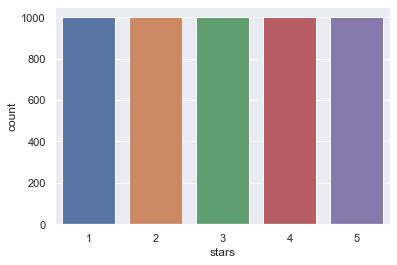

In [4]:
sns.countplot(data = dataset , x='stars')
plt.show()

Queremos responder la pregunta si existe algún tipo de bot que esté generando reviews negativos constantemente, en caso que esta afirmación fuera cierta existiría un reviewer que tendría una cantidad enorme de calificaciones. Pero nos encontramos que el reviewer con más calificaciones tiene 23 estrellas brindadas. 

In [5]:
TopReviewers = dataset.groupby(by=["reviewer_id"]).sum()
print("Tamaño del dataset completo: ",dataset.shape)
print("Tamaño del dataset Con la agrupación por usuarios: ",TopReviewers.shape)
TopReviewers= TopReviewers.sort_values(by='stars',ascending=False)
print(TopReviewers)


Tamaño del dataset completo:  (5000, 8)
Tamaño del dataset Con la agrupación por usuarios:  (4982, 1)
                     stars
reviewer_id               
reviewer_es_0672560      9
reviewer_es_0964440      8
reviewer_es_0024641      8
reviewer_es_0986865      7
reviewer_es_0865785      7
...                    ...
reviewer_es_0273252      1
reviewer_es_0422970      1
reviewer_es_0835958      1
reviewer_es_0153041      1
reviewer_es_0542346      1

[4982 rows x 1 columns]


Cuándo analizamos el reviewer con más calificaciones vemos que son pocas reviews(7) y no representan comentarios negativos por ende concluimos que no existe un bot generando malos reviews.

In [6]:
MaxReview=dataset[dataset['reviewer_id'] == 'reviewer_es_0588051']
MaxReview

,review_id,product_id,reviewer_id,stars,review_body,review_title,language,product_category


Como pregunta adicional a responder del dataset, haremos una exploracion por categorías para saber cuáles son las que más califican los usuarios y cuál es la categoría con más calificaciones sobre 5 y cuáles sobre 1

<AxesSubplot:xlabel='product_category', ylabel='count'>

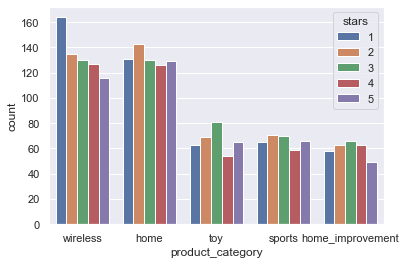

In [7]:
sns.countplot(x="product_category", hue="stars",data=dataset,order=dataset.product_category.value_counts().iloc[:5].index)

Del gráfico anterior se puede observar que la categoría que más reviews tiene es la categoría "wireless" y que dentro de esta la mayoría de las calificaciones son de una estrella y la menor cantidad de calificaciones son de 5 estrellas.

Text(0, 0.5, 'Cantidad')

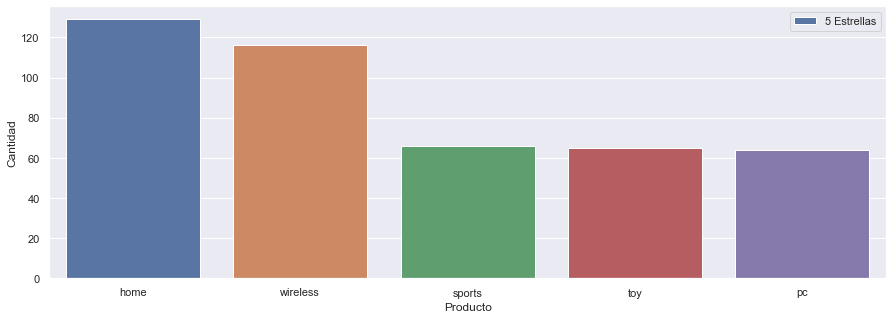

In [8]:
#Filtramos por los registros con 5 estrellas
dataset5stars= dataset[dataset.stars==5]
plt.figure(figsize=(15,5))
#Se realiz ala gráfica solo teniendo en cuenta los 5 categorías principales
sns.countplot(x="product_category",data=dataset5stars,order=dataset5stars.product_category.value_counts().iloc[:5].index)
plt.legend(["5 Estrellas"])
plt.xlabel("Producto")
plt.ylabel("Cantidad")


Del gráfico anterior se puede ver más claro que la categoría que tiene más calificaciones con 5 estrellas es las de "home"

Text(0, 0.5, 'Cantidad')

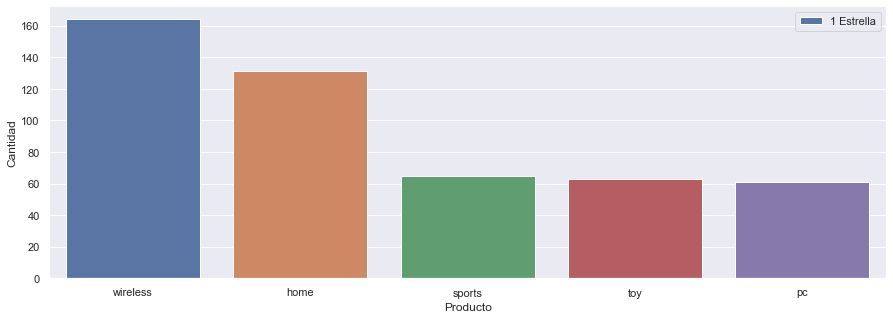

In [9]:
#Filtramos por los registros con solo una estrella
dataset1star= dataset[dataset.stars==1]
plt.figure(figsize=(15,5))
#Se realiz ala gráfica solo teniendo en cuenta los 5 categorías principales
sns.countplot(x="product_category",data=dataset1star,order=dataset1star.product_category.value_counts().iloc[:5].index)
plt.legend(["1 Estrella"])
plt.xlabel("Producto")
plt.ylabel("Cantidad")


el gráfico anterior es de cuántas calificaciones negativas de 1 por categoría se tienen en el dataset. Al final podemos observar que la categoría "wireless" tiene la mayor cantidad de calificaciones negativas con valor 1.

#### Preparación del dasaet para llevarlo al modelo

Para el entrenamiento de nuestro modelo tomaremos solamente las columnas review body,review title y la columna stars

In [10]:
#tomamos las columnas review body,review title y la columna stars
dataset = dataset.iloc[:,[4,5,3]]
#Eliminamos registro vacíos
dataset.dropna(axis=0,inplace=True)  # Si hay alguna nan, tiramos esa instancia
dataset.head()

,review_body,review_title,stars
0,"Malisimo, muy grande demasiado aparatoso y mal...",Mala compra,1
1,No he recibido el pedido no la devolución,No lo he recibido,1
2,"Tengo que buscar otro sistema, este no funcion...",Que no aprieta bien en el manillar,1
3,Utilicé las brocas de menor diámetro y se me d...,Brocas de mantequilla,1
4,No me gusta su olor a viejo y aspecto malo,No me gusta,1


Creamos una columna nueva que es la concatenación entre reviewbody y review title para así tener una columna con más información.

In [11]:
# Creamos columna nueva con la información del review body y el review title
dataset["ReviewConcat"] = dataset.review_title+ " " + dataset.review_body
dataset.head()

,review_body,review_title,stars,ReviewConcat
0,"Malisimo, muy grande demasiado aparatoso y mal...",Mala compra,1,"Mala compra Malisimo, muy grande demasiado apa..."
1,No he recibido el pedido no la devolución,No lo he recibido,1,No lo he recibido No he recibido el pedido no ...
2,"Tengo que buscar otro sistema, este no funcion...",Que no aprieta bien en el manillar,1,Que no aprieta bien en el manillar Tengo que b...
3,Utilicé las brocas de menor diámetro y se me d...,Brocas de mantequilla,1,Brocas de mantequilla Utilicé las brocas de me...
4,No me gusta su olor a viejo y aspecto malo,No me gusta,1,No me gusta No me gusta su olor a viejo y aspe...


In [12]:
#Cargamos los stopwprds en español
stopwords = nltk.corpus.stopwords.words('spanish')
#stopwords

In [13]:
# Importamos esta libreria que nos permite reemplzar caracteres
import re

# Importamos la función que nos permite Stemmizar de nltk y definimos el stemmer

from nltk.stem import SnowballStemmer
stemmer = SnowballStemmer('spanish')


In [14]:
# Recorremos los reviews y le vamos aplicando la Normalizacion y luega el Stemming a cada uno
review_list=[]
for review in dataset.ReviewConcat:
   
        # Pasamos todo a minúsculas
    review=review.lower()
     # Vamos a reemplzar los caracteres que no sean leras por espacios
    review=re.sub("[^a-zA-ZáéíóúÁÉÍÓÚ]"," ",str(review))
   

    
    # Tokenizamos para separar las palabras del titular
    review=nltk.word_tokenize(review)

    # Eliminamos las palabras de menos de 2 letras
    review = [palabra for palabra in review if len(palabra)>2]
    # Sacamos las Stopwords
    review = [palabra for palabra in review if not palabra in stopwords]
    #Creo varieble con contiendo de reiew
    ReviewSinStemmer= review
    
    ## Hasta acá Normalizamos, ahora a stemmizar
    
    # Aplicamos la funcion para buscar la raiz de las palabras
    review=[(stemmer.stem(palabra)) for palabra in review]
  
    #print(review)
    #review=[palabra for palabra in review]
    # Por ultimo volvemos a unir el titular
    review=" ".join(review)
    ReviewSinStemmer= " ".join(ReviewSinStemmer)
    
    # Vamos armando una lista con todos los titulares
    review_list.append(review)

 Durante el proceso de aplicar el stemmer se observó diferencias grandes entre los review sin stmmer y con stemmer al principio se pensó que estas diferencias significativas eran debido a un error pero luego de hacer la respectiva revisión de la librería del stemmer en español se encontró que internamente hace una especie de obtención de la raíz de la palabra pero de una forma no cotidiana en español, la librería tiene su propio diccionario para realizar esta operación. Comparto el enlace dónde se observó dichas diferencias http://snowball.tartarus.org/algorithms/spanish/diffs.txt


In [15]:
#diferencias entre los review con sttemer y sin setmmer
print("Sin Stemmer: ",ReviewSinStemmer)
print("Con Stemmer: ",review)


Sin Stemmer:  buena calidad artículo cumplido expectativas deseaba
Con Stemmer:  buen calid articul cumpl expect des


In [16]:
#columna nueva con la stematización
dataset["review_stem"] = review_list
dataset.tail()

,review_body,review_title,stars,ReviewConcat,review_stem
4995,Me ha encantado la cesta. Ha llegado impecable...,guadalupe,5,guadalupe Me ha encantado la cesta. Ha llegado...,guadalup encant cest lleg impec tam util pes f...
4996,Desempeña su función correctamente,calidad precio,5,calidad precio Desempeña su función correctamente,calid preci desemp funcion correct
4997,Me ha encantado la diadema! Las flores son tal...,Excelente,5,Excelente Me ha encantado la diadema! Las flor...,excelent encant diadem flor tal vien imag ven ...
4998,"A mi me gustan mucho las fundas TPU, ya que so...",Genial,5,"Genial A mi me gustan mucho las fundas TPU, ya...",genial gust fund tpu fund normal fin color hac...
4999,El artículo ha cumplido con las expectativas q...,Buena calidad,5,Buena calidad El artículo ha cumplido con las ...,buen calid articul cumpl expect des


In [17]:
#Conversión a lista de la columna stematizada
list_review_stem = list(dataset['review_stem'].values)
#nos quedamos con el array de los valores de la califación
Calification = dataset['stars'].values

Vampos a vectorizar utilizando la función CountVectorizer y el TfidfVectorizer de ScikitLearn la cual creará un vector a partir de la frecuencia de cada palabra en el texto. En el proyecto 3 se planteó como una posibilidad de mejorael uso de TfidfVectorizer veremos si efectivamente tiene efectos signficativos

In [18]:
#CountVectorizer
from sklearn.feature_extraction.text import CountVectorizer
# Usaremos solo las 10000 palabras con mas frecuencia en todo el corpus para generar los vectores
max_features=10000

# Es decir que cada instancia tendrá 1000 features
cou_vec=CountVectorizer(max_features=max_features) 
#Le pasamos nuestra lista de palabras al objeto cou_vec
matriz_reviews = cou_vec.fit_transform(list_review_stem)
# Tomamos las palabras
all_words = cou_vec.get_feature_names()

# Vizualizamos 50 de las palabras mas usadas
#print("50 palabras mas usadas: ",all_words[0:50])

In [ ]:
#TfidfVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
# Usaremos solo 10000 features
max_features=10000

# Es decir que cada instancia tendrá 1000 features
Tfidf_vec=TfidfVectorizer(max_features=max_features) 

#Le pasamos nuestra lista de palabras al objeto cou_vec
matriz_reviews_Tfidf= Tfidf_vec.fit_transform(list_review_stem)
# Tomamos las palabras
all_words = Tfidf_vec.get_feature_names()
# Vizualizamos 50 de las palabras mas usadas
#print("50 palabras mas usadas: ",all_words[0:50])

## Modelos con Count vectorizer

In [20]:
#pasamos de matriz a array la variable matriz_reviews
x = matriz_reviews.toarray()
y = Calification

#Hacemos la separación en data entrenamiento y pruebas
xtrain, xtest, ytrain, ytest = train_test_split(x,y,test_size=0.3,random_state=42,stratify=y)

In [21]:
#Aplicamos un modelo de bayes simple

nb = GaussianNB()
nb.fit(xtrain,ytrain)
y_predTrain=nb.predict(xtrain)
y_pred=nb.predict(xtest)
#---------Train----------
F1_Score_NBTrain= f1_score(ytrain, y_predTrain, average='macro')
print("F1 Score NB Train= ",F1_Score_NBTrain)
#---------Test----------
F1_Score_NBTEST= f1_score(ytest, y_pred, average='macro')
print("F1 Score NB TEST= ",F1_Score_NBTEST)


F1 Score NB Train=  0.7723180349131589
F1 Score NB TEST=  0.2877054546650875


In [22]:
#Aplicamos un modelo de Random forest con parámetros por defecto

rf = RandomForestClassifier(n_estimators = 50, random_state=42)
rf.fit(xtrain,ytrain)
y_predTrain=rf.predict(xtrain)
y_pred=rf.predict(xtest)
#---------Train----------
F1_Score_forestTrain= f1_score(ytrain, y_predTrain, average='macro')
print("F1 Score NB Train= ",F1_Score_forestTrain)
#---------Test----------
F1_Score_forestTEST= f1_score(ytest, y_pred, average='macro')
print("F1 Score NB TEST= ",F1_Score_forestTEST)

F1 Score NB Train=  1.0
F1 Score NB TEST=  0.41184517415110483


In [23]:
#Aplicamos un modelo de svc con parámetros por defecto
# Notar que en vez de utilizar SVC, vamos a usar LinearSVC. 
# Para el Kernel Lineal, esta función es MUCHO mas rapida que la tradicional SVC.


svc = LinearSVC(C = 1,max_iter=1000)
svc.fit(xtrain,ytrain)
y_predTrain=svc.predict(xtrain)
y_pred=svc.predict(xtest)
#---------Train----------
F1_Score_svcTrain= f1_score(ytrain, y_predTrain, average='macro')
print("F1 Score NB Train= ",F1_Score_svcTrain)
#---------Test----------
F1_Score_svcTEST= f1_score(ytest, y_pred, average='macro')
print("F1 Score NB TEST= ",F1_Score_svcTEST)

F1 Score NB Train=  0.9785587796228926
F1 Score NB TEST=  0.40119218979615423


## Modelos con TfidfVectorizer

In [20]:
#pasamos de matriz a array la variable matriz_reviews
x = matriz_reviews_Tfidf.toarray()
y = Calification

#Hacemos la separación en data entrenamiento y pruebas
xtrain, xtest, ytrain, ytest = train_test_split(x,y,test_size=0.3,random_state=42,stratify=y)

In [21]:
#Aplicamos un modelo de bayes simple

nb = GaussianNB()
nb.fit(xtrain,ytrain)
y_predTrain=nb.predict(xtrain)
y_pred=nb.predict(xtest)
#---------Train----------
F1_Score_NBTrain= f1_score(ytrain, y_predTrain, average='macro')
print("F1 Score NB Train= ",F1_Score_NBTrain)
#---------Test----------
F1_Score_NBTEST= f1_score(ytest, y_pred, average='macro')
print("F1 Score NB TEST= ",F1_Score_NBTEST)


F1 Score NB Train=  0.7723180349131589
F1 Score NB TEST=  0.2877054546650875


In [22]:
#Aplicamos un modelo de Random forest con parámetros por defecto

rf = RandomForestClassifier(n_estimators = 50, random_state=42)
rf.fit(xtrain,ytrain)
y_predTrain=rf.predict(xtrain)
y_pred=rf.predict(xtest)
#---------Train----------
F1_Score_forestTrain= f1_score(ytrain, y_predTrain, average='macro')
print("F1 Score NB Train= ",F1_Score_forestTrain)
#---------Test----------
F1_Score_forestTEST= f1_score(ytest, y_pred, average='macro')
print("F1 Score NB TEST= ",F1_Score_forestTEST)

F1 Score NB Train=  1.0
F1 Score NB TEST=  0.41184517415110483


In [23]:
#Aplicamos un modelo de svc con parámetros por defecto
# Notar que en vez de utilizar SVC, vamos a usar LinearSVC. 
# Para el Kernel Lineal, esta función es MUCHO mas rapida que la tradicional SVC.


svc = LinearSVC(C = 1,max_iter=1000)
svc.fit(xtrain,ytrain)
y_predTrain=svc.predict(xtrain)
y_pred=svc.predict(xtest)
#---------Train----------
F1_Score_svcTrain= f1_score(ytrain, y_predTrain, average='macro')
print("F1 Score NB Train= ",F1_Score_svcTrain)
#---------Test----------
F1_Score_svcTEST= f1_score(ytest, y_pred, average='macro')
print("F1 Score NB TEST= ",F1_Score_svcTEST)

F1 Score NB Train=  0.9785587796228926
F1 Score NB TEST=  0.40119218979615423


## Resultados Countvectorizer vs TfIdf

Conclusiones de la comparación

La siguiente gráfica representa los comportamientos de los valores predichos por el modelo y los valores reales. se observa por ejemplo que cuando el valor real es 5 el valor predicho puede ser un 4 lo cual es bastante cercano, pero al verlo como un problema de clasificación las métricas se ven muy castigas, por ende se sugiere trabajarlo en el proyecto 4 como un modelo de regresión y establecer umbrales para las categorías.

Text(0, 0.5, 'Estrellas')

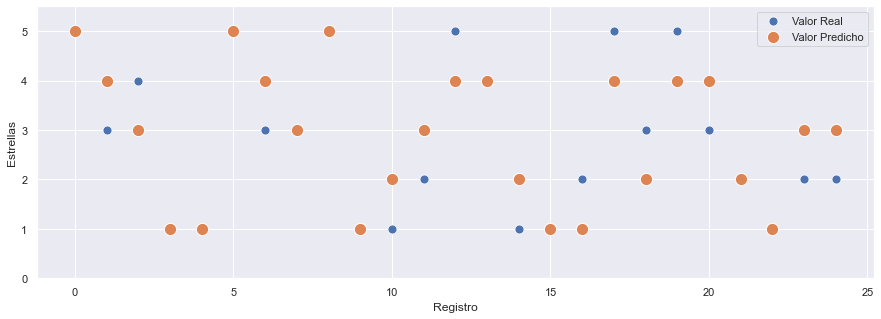

In [24]:
plt.figure(figsize=(15,5))
sns.scatterplot(data=ytest[0:25], x=np.arange(len(ytest[0:25])),y=ytest[0:25], s=80)
sns.scatterplot(data=y_pred[0:25], x=np.arange(len(y_pred[0:25])),y=y_pred[0:25], s=150)
plt.legend(["Valor Real","Valor Predicho"])
plt.ylim(0, 5.5)
plt.xlabel("Registro")
plt.ylabel("Estrellas")

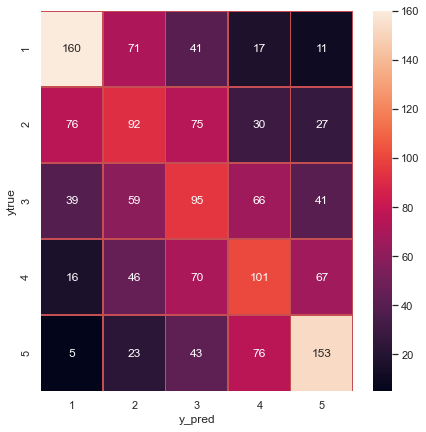

In [25]:


def confusion(ytest,y_pred):
    names=["1","2","3","4","5"]
    cm=confusion_matrix(ytest,y_pred)
    f,ax=plt.subplots(figsize=(7,7))
    sns.heatmap(cm,annot=True,linewidth=.5,linecolor="r",fmt=".0f",ax=ax)
    plt.xlabel("y_pred")
    plt.ylabel("ytrue")
    ax.set_xticklabels(names)
    ax.set_yticklabels(names)
    plt.show()

    return
confusion(ytest,y_pred)


Imprimimos la matriz de confusión y vemos que tiene una diagonal con valores altos lo que significa que logra predecir buena cantidad de los valores reales, pero adicional vemos que los valores extemos (1,5) son los que presentan mejor comportamiento. Cómo era de esperarse alrededor del 3 hay gran variabilidad porque puede que el modelo lo tome como un 2 o un 4 y no como el 3.

# Aplicación de modelos de regresión

Como se menciono en el proyecto anterior vamos a probar con modelos de regresión y no de clasificación ya que en este caso la clasificación (1-5) tiene un orden y un modelo de clasificación no tiene en cuenta este factor.

In [26]:
#Aplicamos un modelo de Random forest con parámetros por defecto


rf = RandomForestRegressor(n_estimators = 25, random_state=42)
rf.fit(xtrain,ytrain)
y_predTrain=rf.predict(xtrain)
y_pred=rf.predict(xtest)
#---------Train----------
RMSE_forestTrain= np.sqrt(metrics.mean_squared_error(ytrain, y_predTrain))
print("Valor RMSE modelo RandoForest TRAIN: ",RMSE_forestTrain)
#---------Test----------
RMSE_forestTEST= np.sqrt(metrics.mean_squared_error(ytest, y_pred))
print("Valor RMSE modelo RandoForest TEST: ",RMSE_forestTEST)



Valor RMSE modelo RandoForest TRAIN:  0.4211635583204497
Valor RMSE modelo RandoForest TEST:  1.0981244616769692


In [27]:
#Aplicamos un modelo de svr con parámetros por defecto
# vamos a usar SVR. 

svr = SVR(kernel = 'rbf')
svr.fit(xtrain,ytrain)
y_predTrain=svr.predict(xtrain)
y_pred=svr.predict(xtest)
#---------Train----------
RMSE__svrTrain= np.sqrt(metrics.mean_squared_error(ytrain, y_predTrain))
print("Valor RMSE modelo SVR TRAIN: ",RMSE__svrTrain)
#---------Test----------
RMSE__svrTEST= np.sqrt(metrics.mean_squared_error(ytest, y_pred))
print("Valor RMSE modelo SVR TEST: ",RMSE__svrTEST)


Valor RMSE modelo SVR TRAIN:  0.619227210390104
Valor RMSE modelo SVR TEST:  1.0484800461001755


Aplicamos el random search para encontrar los mejores parámetros tanto para el árbol de decisión como para el SVR. 

In [28]:
#Probamos GridSearch para una mejor determinación de hiperparámetros del random forest

tree= RandomForestRegressor()
param_grid = {"min_samples_split": [4, 8, 12],
              "max_depth": [4,8,12],
              "min_samples_leaf": [8,12 ],
              }

# ESTRATEGIA 2: Random Search
grid_rf = RandomizedSearchCV(tree, param_grid,n_iter=10, random_state=0,n_jobs=-1)

grid_rf.fit(xtrain,ytrain)
print("Mejores parametros: "+str(grid_rf.best_params_))

Mejores parametros: {'min_samples_split': 12, 'min_samples_leaf': 8, 'max_depth': 16}


In [29]:
#Evaluamos el mejor  random forest
y_predTrain=grid_rf.predict(xtrain)
y_pred=grid_rf.predict(xtest)
#---------Train----------
RMSE_forestTrain= np.sqrt(metrics.mean_squared_error(ytrain, y_predTrain))
print("Valor RMSE mejor modelo RandomForest TRAIN: ",RMSE_forestTrain)
#---------Test----------
RMSE_forestTEST= np.sqrt(metrics.mean_squared_error(ytest, y_pred))
print("Valor RMSE mejor modelo RandomForest TEST: ",RMSE_forestTEST)



Valor RMSE mejor modelo RandomForest TRAIN:  1.031519879524302
Valor RMSE mejor modelo RandomForest TEST:  1.118278970994254


ahora encontramos los mejores hiperparámetros para el SVR

In [30]:
#Probamos GridSearch para una mejor determinación de hiperparámetros del SVR
svr = SVR()
param_grid = { 'C' : [1,10],
               'degree' : [4,6,8],
               'coef0' : [0,0.01,0.1],
               'max_iter':[1500],
               'gamma':['auto']
              }

# ESTRATEGIA 2: SVR
grid_SVR = RandomizedSearchCV(svr, param_grid,n_iter=10, random_state=0,n_jobs=-1,verbose=1)
#Entrenamos con el modelo con los parámetros optimizados
grid_SVR.fit(xtrain,ytrain)
print("Mejores parametros: "+str(grid_SVR.best_params_))

Fitting 5 folds for each of 15 candidates, totalling 75 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed: 16.1min
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed: 32.8min finished


Mejores parametros: {'max_iter': 1500, 'gamma': 'auto', 'degree': 6, 'coef0': 0, 'C': 10}


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


In [31]:
y_predTrain=grid_SVR.predict(xtrain)
y_pred=grid_SVR.predict(xtest)
#---------Train----------
RMSE__svrTrain= np.sqrt(metrics.mean_squared_error(ytrain, y_predTrain))
print("Valor RMSE modelo SVR TRAIN: ",RMSE__svrTrain)
#---------Test----------
RMSE__svrTEST= np.sqrt(metrics.mean_squared_error(ytest, y_pred))
print("Valor RMSE modelo SVR TEST: ",RMSE__svrTEST)

Valor RMSE modelo SVR TRAIN:  1.0830852602505345
Valor RMSE modelo SVR TEST:  1.1437050444895456


Luego de ejecutar el random search se obtuvo lo siguientes Mejores parametros: {'max_iter': 1000, 'kernel': 'rbf', 'gamma': 'auto', 'degree': 8, 'coef0': 0.1, 'C': 10}

Mejores parametros: {'max_iter': 1000, 'gamma': 'auto', 'degree': 4, 'coef0': 0.01, 'C': 10}

In [32]:
#print(y_pred[0:1000])
#print(ytest[0:25])
print(y_pred.min())
print(y_pred.max())


-0.025705230821064018
5.98039924888799


In [33]:
#Vamos a normalizar los resultados obtenidos por el mejor modelo de regresión,
#para esto vamos a tener los rangos dentro de los condicionales
y_PredNorm=[]
for i in y_pred:
    if i <= 2:
        y_PredNorm.append(1)
        
    elif i > 2 and i <= 2.62:
        y_PredNorm.append(2)
        
    elif i > 2.62 and i < 3.22:
        y_PredNorm.append(3)
        
    elif i >= 3.22 and i < 3.96:
           y_PredNorm.append(4)
    elif i >= 3.96:
           y_PredNorm.append(5)
y_PredNorm=np.array(y_PredNorm)

Text(0, 0.5, 'Estrellas')

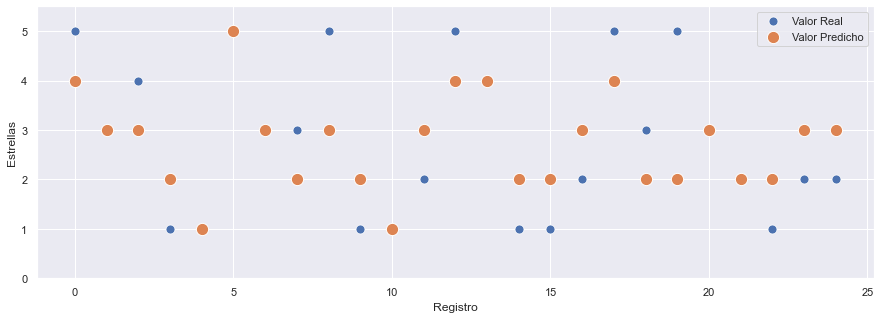

In [34]:
#Graficamos los valores predichos vs los valores reales
plt.figure(figsize=(15,5))
sns.scatterplot(data=ytest[0:25], x=np.arange(len(ytest[0:25])),y=ytest[0:25], s=80)
sns.scatterplot(data=y_PredNorm[0:25], x=np.arange(len(y_PredNorm[0:25])),y=y_PredNorm[0:25], s=150)
plt.legend(["Valor Real","Valor Predicho"])
plt.ylim(0, 5.5)
plt.xlabel("Registro")
plt.ylabel("Estrellas")

Esta gráfica nos muestra lo que veiamos en los resultados del RMSE que el error en la clasificación está en promedio +-1 estrella lo cual el comportamiento de los modelos es adecuado.

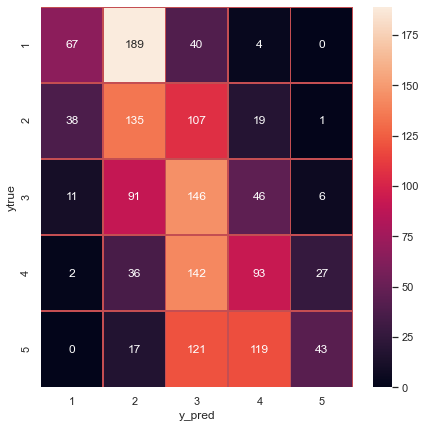

In [35]:

def confusion(ytest,y_PredNorm):
    names=["1","2","3","4","5"]
    cm=confusion_matrix(ytest,y_PredNorm)
    f,ax=plt.subplots(figsize=(7,7))
    sns.heatmap(cm,annot=True,linewidth=.5,linecolor="r",fmt=".0f",ax=ax)
    plt.xlabel("y_pred")
    plt.ylabel("ytrue")
    ax.set_xticklabels(names)
    ax.set_yticklabels(names)
    plt.show()

    return
confusion(ytest,y_PredNorm)


Imprimimos la matriz de confusión y vemos que al igual que la matriz de confusión realizada para los modelos de clasificación tiene una diagonal con valores altos lo que significa que logra predecir buena cantidad de los valores reales, una diferencia significativa es que en los valorez extremos (1,5) tiene un comportamiento un poco inferior para clasificarlos que el modelo de clasificación pero en los valores medios el modelo de regresión tiene un mejor comportamiento. además es mucho menos probable encontrar un error grande (un 1 clasificado como 5 o viceversa). Por ende se puede concluir que el modelo de regresión aplicado con los rango para la normalización tiene mejor comportamiento que el modelo de clasificación realizado en el proyecto 3 

Conclusiones

Con modelos de clasificación Se intentó evaluar 3 modelos básicos bayes(benchmark), random forest y SVC. se vió que el random forest y el SVC lograron mejores resultados que el modelo benchmark era de esperarse ya que son modelos más complejos. Entre SVC y random forest se elige el SVC ya que se ejecutó más rápido y además presentó mejores resultados de f1score que fue la métrica para la evaluación de los modelos

Como conclusión tanto con un modelo de clasificación como con un modelo de regresión se pudo crear un modelo de una máquina de soporte vectorial que puede decir el número de estrellas que puede tener un comentario a partir del titulo y el body del review, pero arrojó resultados más optimos el modelo de regresión.

El modelo de regresión tuvo un mejor comportamiento que el modelo de clasificación ya que aqui importa el orden de los registro y en la clasificación no, además el error que se obtuvo fue de aproximadamente 1 en el RMSE lo cual dice que es muy poco probable que una review calificada en 1 el modelo de una predicción de 5. lo cual también se puede observar en la matriz de confusión anterior

Como trabajo a futuro se podría pensar en crear modelos con redes neuronales que la literatura menciona como los modelos más indicados para el trabajo con NLP

El proyecto puede verse también en mi github https://github.com/juanbetancur96/AmazonNLP
